In [1]:
import xgcm, xarray as xr
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco
import matplotlib.pyplot as plt
import numpy as np
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import warnings
import os, glob
import pandas as pd
warnings.filterwarnings("ignore")
from dask.distributed import Client, LocalCluster
from matplotlib import animation
from IPython.display import HTML
cluster = LocalCluster(n_workers=4, threads_per_worker=20)
client = Client(cluster)

In [2]:
def depthIntVelocity_i(field):
    """Time mean and depth integrated version of the given field on tracer point."""
    return (field * np.array(dg.drF * dg.hFacW)).sum(dim='k')

def depthIntVelocity_j(field):
    """Time mean and depth integrated version of the given field on tracer point."""
    return (field * np.array(dg.drF * dg.hFacS)).sum(dim='k')

In [3]:
dg = xr.open_mfdataset('/home/jovyan/efs_ecco/bdarby/data/ECCO_V4r4_PODAAC/grid/*.nc')

In [41]:
path = '/efs_ecco/V4r5/V4r5/native/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS/'
ds0 = xr.open_mfdataset(path+'*_1992-0[1-2]*_ECCO_V4r5_native_llc0090.nc', parallel = True,)
ds = xr.merge([ds0,dg])

In [59]:
face_connections = {'tile':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

# create the grid object
grid = xgcm.Grid(ds, periodic=False, boundary = None, face_connections=face_connections)

In [ ]:
ADVx_TH    (time, k, face, j, i_g) float32 dask.array<shape=(288, 50, 13, 90, 90), chunksize=(1, 50, 13, 90, 90)>


In [63]:
ds.oceTAUX

<xarray.DataArray 'oceTAUX' (time: 2, tile: 13, j: 90, i_g: 90)> Size: 842kB
dask.array<concatenate, shape=(2, 13, 90, 90), dtype=float32, chunksize=(1, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 16B 1992-01-16T18:00:00 1992-02-15T12:00:00
Attributes:
    valid_min:              -0.5122126
    valid_max:              0.44371736
    coverage_content_type:  modelResult
    direction:               >0 increases horizontal velocity in the +x direc...
    long_name:              Ocean surface stress in the model +x direction
    standard_name:          downward_x_stress_at_sea_water_surface
    units:                  N m-2
    comment:                Ocean surface stress due to wind and sea-ice in t...

In [65]:
grid.diff_2d_vector({'X': ds.oceTAUY, 'Y': ds.oceTAUX}, boundary='fill')

NotImplementedError: Only vector interpolation to cell center is implemented, but vector X component is defined at center (dims: ('time', 'tile', 'j_g', 'i'))

In [60]:
#taux = ds.oceTAUX*dg.maskW.isel(k=0)
#tauy = ds.oceTAUY*dg.maskS.isel(k=0)

udx = ds.oceTAUX*ds.dxC*dg.maskW.isel(k=0).chunk({'j':90,'i_g':90, 'tile':13})
vdy = ds.oceTAUY*ds.dyC*dg.maskS.isel(k=0).chunk({'j_g':90,'i':90, 'tile':13})
rho0=1029
zeta = (-grid.diff(udx, 'Y') + grid.diff(vdy, 'X'))/ds.rAz/rho0

In [8]:
zeta2 = zeta.copy()
zeta2[:,0:3,:,0] = np.array(zeta[:,0:3,:,1])
zeta2[:,7:10,0,:] = np.array(zeta[:,7:10,1,:])
zeta2[:,6,:,0] = np.array(zeta[:,6,:,1])

In [58]:
grid

<xgcm.Grid>
Z Axis (not periodic, boundary='extend'):
  * center   k --> left
  * right    k_u --> center
  * left     k_l --> center
  * outer    k_p1 --> center
X Axis (not periodic, boundary='extend'):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic, boundary='extend'):
  * center   j --> left
  * left     j_g --> center
T Axis (not periodic, boundary='extend'):
  * center   time

In [9]:
#((zeta2*dg.rAz).sum(dim=['tile','i_g','j_g'])/dg.rAz.sum()).plot()

In [56]:
index = 0
time_value = ds.time[index].values
date=pd.Timestamp(time_value).strftime('%Y-%m')

Text(0.5, 1.0, '$ \\dfrac{1}{\\rho_{0}} \\nabla \\times \\boldsymbol{\\tau}$, 1992-01')

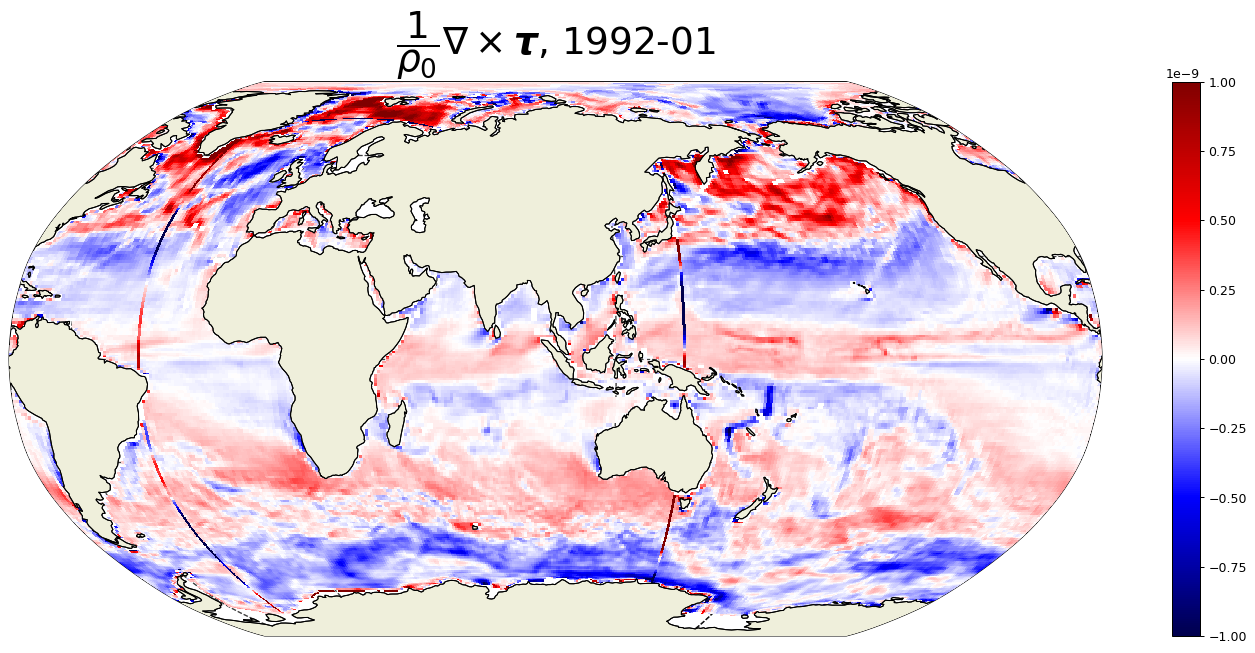

In [57]:
plt.figure(figsize=(20,8), dpi= 90)
curr_obj = ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,\
                                         zeta.isel(time=index),\
                                         show_colorbar=True,\
                                         show_land=True,projection_type='robin',\
                                         user_lon_0=100,plot_type='pcolormesh',\
                                         cmin=-1e-9, cmax=1e-9,\
                                         cmap='seismic')
plt.title(""+r"$ \dfrac{1}{\rho_{0}} \nabla \times \boldsymbol{\tau}$, "+date,size=30)

In [4]:
path = '/efs_ecco/V4r5/V4r5/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_X/'
ds0 = xr.open_mfdataset(path+'*_1992-0[1-2]*_ECCO_V4r5_native_llc0090.nc', parallel = False,)
path = '/efs_ecco/V4r5/V4r5/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_Y/'
ds1 = xr.open_mfdataset(path+'*_1992-0[1-2]*_ECCO_V4r5_native_llc0090.nc', parallel = False,)
ds = xr.merge([dg, ds0, ds1])

In [7]:
Um_Cori_int = depthIntVelocity_i(ds.Um_Cori)
Vm_Cori_int = depthIntVelocity_j(ds.Vm_Cori)
zeta_cori_bt = (-grid.diff(Um_Cori_int.chunk({'j':90,'i_g':90, 'tile':13}) * dg.dxC, 'Y') + 
                grid.diff(Vm_Cori_int.chunk({'j_g':90,'i':90, 'tile':13}) * dg.dyC, 'X'))/dg.rAz

zeta_cori_bt[:,0:3,:,0] = np.array(zeta_cori_bt[:,0:3,:,1])
zeta_cori_bt[:,7:10,0,:] = np.array(zeta_cori_bt[:,7:10,1,:])
zeta_cori_bt[:,6,:,0] = np.array(zeta_cori_bt[:,6,:,1])

In [ ]:
#((zeta_cori_bt*dg.rAz).sum(dim=['tile','i_g','j_g'])/dg.rAz.sum()).plot()

Text(0.5, 1.0, '$ \\nabla \\cdot (f\\mathbf{U})$, 1992-01')

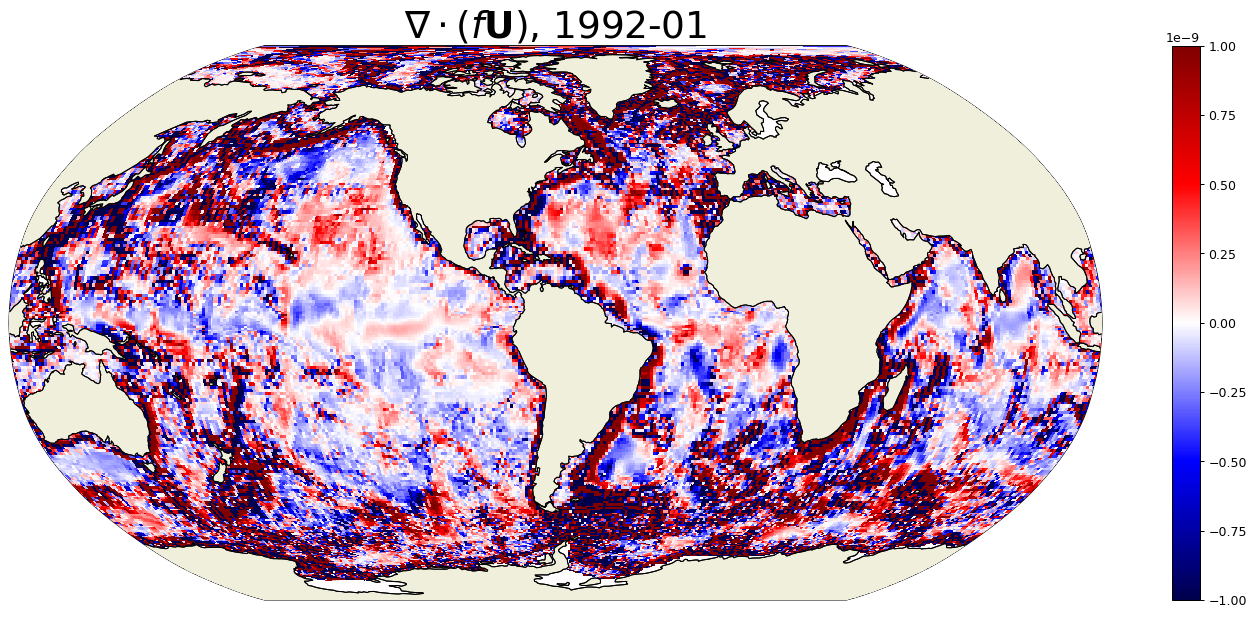

In [10]:
plt.figure(figsize=(20,8), dpi= 90)
curr_obj = ecco.plot_proj_to_latlon_grid(dg.XG,dg.YG,\
                                         zeta_cori_bt.isel(time=index),\
                                         show_colorbar=True,\
                                         show_land=True,projection_type='robin',\
                                         user_lon_0=-67,plot_type='pcolormesh',\
                                         cmin=-1e-9, cmax=1e-9,\
                                         cmap='seismic')
plt.title(r"$ \nabla \cdot (f\mathbf{U})$, " +date,size=30)

In [11]:
Um_Advec_int = depthIntVelocity_i(ds.Um_Advec)
Vm_Advec_int = depthIntVelocity_j(ds.Vm_Advec)
AB_gU_int = depthIntVelocity_i(ds.AB_gU)
AB_gV_int = depthIntVelocity_j(ds.AB_gV)

zeta_Adv_int = (-grid.diff(Um_Advec_int.chunk({'j':90,'i_g':90, 'tile':13}) * np.array(dg.dxC), 'Y') + 
                grid.diff(Vm_Advec_int.chunk({'j_g':90,'i':90, 'tile':13}) * np.array(dg.dyC), 'X'))/dg.rAz
zeta_AB_int = (-grid.diff(AB_gU_int.chunk({'j':90,'i_g':90, 'tile':13}) * dg.dxC, 'Y') + 
               grid.diff(AB_gV_int.chunk({'j_g':90,'i':90, 'tile':13}) * dg.dyC, 'X'))/dg.rAz
zeta_B_bt = (zeta_Adv_int-zeta_cori_bt)+zeta_AB_int

zeta_B_bt[:,0:3,:,0] = np.array(zeta_B_bt[:,0:3,:,1])
zeta_B_bt[:,7:10,0,:] = np.array(zeta_B_bt[:,7:10,1,:])
zeta_B_bt[:,6,:,0] = np.array(zeta_B_bt[:,6,:,1])

Text(0.5, 1.0, '$ \\nabla \\times $B, 1992-01')

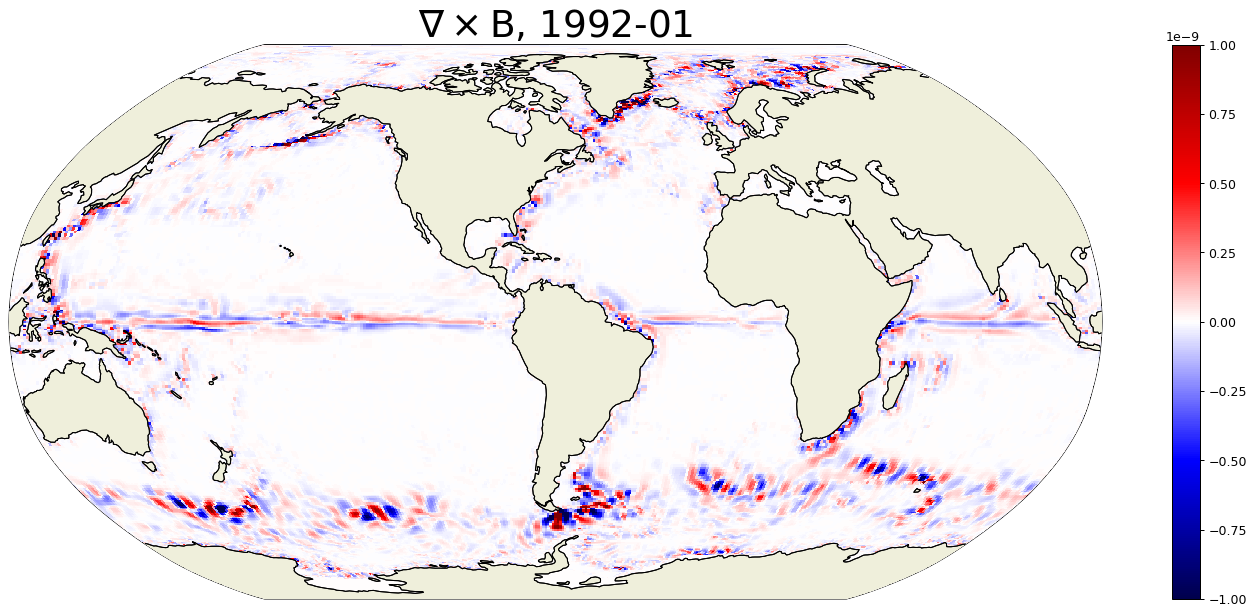

In [12]:
plt.figure(figsize=(20,8), dpi= 90)
curr_obj = ecco.plot_proj_to_latlon_grid(dg.XG,dg.YG,\
                                         zeta_B_bt.isel(time=index),\
                                         show_colorbar=True,\
                                         show_land=True,projection_type='robin',\
                                         user_lon_0=-67,plot_type='pcolormesh',\
                                         cmin=-1e-9, cmax=1e-9,\
                                         cmap='seismic')
plt.title(r"$ \nabla \times $B, "+date,size=30)

In [31]:
md_dir='/efs_ecco/ECCO/V4/r5/diags_monthly/'
grid_dir = '/efs_ecco/ECCO/V4/r5/grid/'
varnm_all = ['VISrI_Um', 'VISrI_Vm']
diags= []
for varnm in varnm_all:
    filename=varnm+'_mon_mean'
    ds_tmp = ecco.load_ecco_vars_from_mds(md_dir+filename, grid_dir,
                                          vars_to_load = [varnm],
                                          mds_files=filename,
                                          output_freq_code='AVG_MON',
                                          #model_time_steps_to_load = 'all',
                                          less_output=True)
    diags.append(ds_tmp)

In [37]:
dg = xr.open_mfdataset('/home/jovyan/efs_ecco/bdarby/data/ECCO_V4r4_PODAAC/grid/*.nc')
face_connections = {'tile':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

# create the grid object
grid = xgcm.Grid(dg, periodic=False, face_connections=face_connections)

In [52]:
diags[0].VISrI_Um

<xarray.DataArray 'VISrI_Um' (time: 173, k_l: 50, tile: 13, j: 90, i_g: 90)> Size: 4GB
dask.array<getitem, shape=(173, 50, 13, 90, 90), dtype=float32, chunksize=(1, 1, 1, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i_g       (i_g) int64 720B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j         (j) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k_l       (k_l) int64 400B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * tile      (tile) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
    Zl        (k_l) >f4 200B dask.array<chunksize=(50,), meta=np.ndarray>
    dyG       (tile, j, i_g) >f4 421kB dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxC       (tile, j, i_g) >f4 421kB dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rAw       (tile, j, i_g) >f4 421kB dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    timestep  (time) int64 1kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) datetime64[ns] 1kB 1992-01-16T12:00:00 ... 2006-05-16T12...
Attributes:
    long_name:  Vertical   Viscous Flux of U momentum (Implicit part)
    units:      m^4/s^2

In [83]:
Um_Diss_int = depthIntVelocity_i(ds.Um_Diss.chunk({'j':90,'i_g':90, 'tile':13}))
Vm_Diss_int = depthIntVelocity_j(ds.Vm_Diss.chunk({'j_g':90,'i':90, 'tile':13}))

latViscU = diags[0].VISrI_Um.isel(time=0)/dg.rAw
gridSpacingU = dg.hFacW*dg.drF
diffZlatViscV = grid.diff(latViscU, 'Z', boundary='fill')
latViscU = depthIntVelocity_i(diffZlatViscV/gridSpacingU)

latViscV = diags[1].VISrI_Vm.isel(time=0)/dg.rAs
gridSpacingV = dg.hFacS*dg.drF
diffZlatViscV = grid.diff(latViscV, 'Z', boundary='fill')
latViscV = depthIntVelocity_j(diffZlatViscV/gridSpacingV)

zeta_Diss_int = (-grid.diff(Um_Diss_int * dg.dxC, 'Y') + 
                 grid.diff(Vm_Diss_int * dg.dyC, 'X'))/dg.rAz
zeta_ViscLat_int = (-grid.diff(latViscU * dg.dxC, 'Y') + 
                    grid.diff(latViscV * dg.dyC, 'X'))/dg.rAz
zeta_A_bt = (zeta_Diss_int-zeta_bottomDrag_int)+zeta_ViscLat_int

NameError: name 'zeta_bottomDrag_int' is not defined

In [78]:
depthIntVelocity_i(ds.Um_Diss.chunk({'j':90,'i_g':90, 'tile':13}))

<xarray.DataArray 'Um_Diss' (time: 2, tile: 13, j: 90, i_g: 90)> Size: 842kB
dask.array<sum-aggregate, shape=(2, 13, 90, 90), dtype=float32, chunksize=(1, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 16B 1992-01-16T18:00:00 1992-02-15T12:00:00

In [71]:
diags[1].VISrI_Vm.isel(time=slice(0,2))

<xarray.DataArray 'VISrI_Vm' (time: 2, k_l: 50, tile: 13, j_g: 90, i: 90)> Size: 42MB
dask.array<getitem, shape=(2, 50, 13, 90, 90), dtype=float32, chunksize=(1, 1, 1, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i         (i) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int64 720B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k_l       (k_l) int64 400B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * tile      (tile) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
    Zl        (k_l) >f4 200B dask.array<chunksize=(50,), meta=np.ndarray>
    dxG       (tile, j_g, i) >f4 421kB dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dyC       (tile, j_g, i) >f4 421kB dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rAs       (tile, j_g, i) >f4 421kB dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    timestep  (time) int64 16B dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) datetime64[ns] 16B 1992-01-16T12:00:00 1992-02-15T12:00:00
Attributes:
    long_name:  Vertical   Viscous Flux of V momentum (Implicit part)
    units:      m^4/s^2

In [63]:
latViscU

<xarray.DataArray (tile: 13, j: 90, i_g: 90)> Size: 421kB
dask.array<sum-aggregate, shape=(13, 90, 90), dtype=float32, chunksize=(1, 45, 45), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12